In [1]:
import numpy as np
from keras.datasets import imdb
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding, Dropout, Conv1D, MaxPool1D, Flatten, Dense, Activation

from keras.callbacks import EarlyStopping, TensorBoard

np.random.seed(0)

Using TensorFlow backend.


In [2]:
word2vec_dir = 'glove.6B.200d.txt'

# embedding
max_features = 20000
max_len = 100
embedding_dim = 200

# conv1d
kernel_size = 5
filters = 64
pool_size = 4

# training
batch_size = 128
epochs = 10

In [3]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

In [4]:
x_train = pad_sequences(x_train, maxlen=max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [5]:
word2idx = imdb.get_word_index()

In [6]:
word2vec = {}
with open(word2vec_dir, encoding='utf8') as f:
    for line in f:
        word_and_vec = line.split()
        word2vec[word_and_vec[0]] = np.asarray(word_and_vec[1:], dtype='float32')

In [7]:
embeddings = np.zeros((max_features, embedding_dim))
for word, idx in word2idx.items():
    if word in word2vec and idx < max_features:
        embeddings[idx] = word2vec.get(word)

In [8]:
model = Sequential()

In [9]:
## embedding
# > (batch_size, seq_len=100)
model.add(Embedding(max_features, embedding_dim, weights=[embeddings], input_length=max_len, trainable=True))
# gru_model.add(Embedding(max_features, embedding_dim, input_length=max_len))
model.add(Dropout(0.25))
# > (batch_size, seq_len=100, embedding_dim=100)

## cnn
model.add(Conv1D(filters, kernel_size, strides=1, activation='relu'))
# > (batch_size, new_seq_len=96, new_nb_features=64)
model.add(MaxPool1D(pool_size=pool_size))
# > (batch_size, downsampling_len=24, nb_features=64)

## flatten
model.add(Flatten())

model.add(Dense(units=1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 200)          4000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 200)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 64)            64064     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 24, 64)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1537      
Total params: 4,065,601
Trainable params: 4,065,601
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [11]:
early_stop = EarlyStopping(monitor='val_loss', verbose=1)
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, callbacks=[early_stop], 
                        validation_split=0.1, verbose=1)

Train on 22500 samples, validate on 2500 samples
Epoch 1/10
22500/22500 [==============================] - 82s - loss: 0.6434 - acc: 0.6066 - val_loss: 0.5165 - val_acc: 0.7520
Epoch 2/10
22500/22500 [==============================] - 77s - loss: 0.3744 - acc: 0.8340 - val_loss: 0.3718 - val_acc: 0.8368
Epoch 3/10
22500/22500 [==============================] - 71s - loss: 0.2504 - acc: 0.8994 - val_loss: 0.3481 - val_acc: 0.8524
Epoch 4/10
22500/22500 [==============================] - 72s - loss: 0.1782 - acc: 0.9311 - val_loss: 0.3630 - val_acc: 0.8528
Epoch 00003: early stopping


In [12]:
test_score, test_acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('\ntest score: ', test_score)
print('test acc: ', test_acc)

24960/25000 [============================>.] - ETA: 0s
test score:  0.365839004383
test acc:  0.846000000038


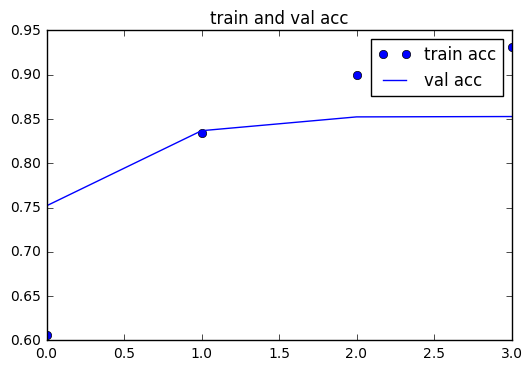

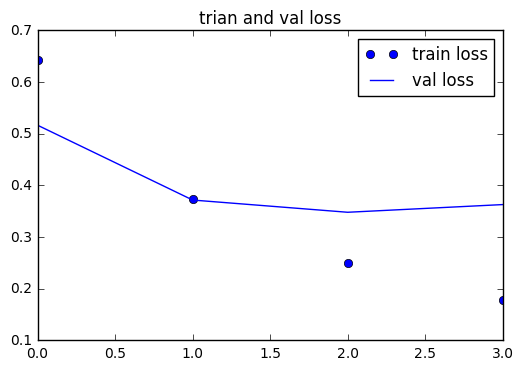

In [13]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'bo', label='train acc')
plt.plot(epochs, val_acc, 'b', label='val acc')
plt.title('train and val acc')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='train loss')
plt.plot(epochs, val_loss, 'b', label='val loss')
plt.title('trian and val loss')
plt.legend()

plt.show()

In [ ]:
test acc:  0.834320000038